In [2]:
from tqdm import tqdm
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid
from scipy.stats import gaussian_kde
import os
import jax.random as random
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from scipy.special import gammaln, log1p, expit
from pathlib import Path
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.stats     import gaussian_kde
from scipy.integrate import trapezoid
from scipy.interpolate import interp1d
from __future__ import annotations
import numpy as np
import xarray as xr
from typing import List, Dict, Any
import os
from pathlib import Path
import numpy as np
import pandas as pd
import jax.random as random
import jax.numpy as jnp
import arviz as az
from numpyro.infer import MCMC, NUTS
import matplotlib as mpl
from datetime import date

In [3]:
# Save beta density histograms as JPEG files
def save_beta_density_hist(
        idata,
        *,
        output_folder: str | Path,
        experiment: str,
        regex: str = r"beta_\d+",
        bins: int = 40,
        dpi: int = 300,
):
    """
    One figure per beta variable (KDE + histogram) written to
    {output_folder}/{experiment}_{varname}.jpg.
    Histogram now shows *frequency* and the x-axis label is removed.
    """
    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)

    posterior = idata.posterior
    var_names = [v for v in posterior.data_vars if re.fullmatch(regex, v)]
    if not var_names:
        raise ValueError(f"No variables match pattern {regex!r}")

    for var in var_names:
        draws = posterior[var].values.reshape(-1)

        fig, (ax_kde, ax_hist) = plt.subplots(
            2, 1,
            figsize=(6, 4),
            sharex=True,
            gridspec_kw={"height_ratios": (2, 1)},
        )

        # KDE (top)
        az.plot_kde(draws, ax=ax_kde, plot_kwargs={"color": "steelblue"})
        ax_kde.set_ylabel("Density")
        ax_kde.set_title("")  # no title
        ax_kde.set_xlabel("")  # remove x-axis label
        ax_kde.grid(True)

        # Histogram (bottom) — raw counts
        ax_hist.hist(draws, bins=bins, density=False,
                     color="steelblue", alpha=0.6)
        ax_hist.set_ylabel("Frequency")
        ax_hist.set_xlabel("")  # remove x-axis label
        ax_hist.grid(True)

        fig.tight_layout()

        fname = output_folder / f"{experiment}_{var}.jpg"
        fig.savefig(fname, dpi=dpi, bbox_inches="tight")
        plt.close(fig)
    print(f"Saved experiment {experiment} beta densities to {output_folder}")


# Plot empirical prior vs posterior KDEs
def plot_df_prior_vs_posterior(
        df_sim,
        idata,
        *,
        kde_bw: str | float | None = None,  # bandwidth for gaussian_kde
        density_cut: float = 1e-3,  # threshold for x-axis limits
        xgrid_len: int = 2000,
        save_to: str | Path | None = None,
):
    """
    Overlay empirical prior (from profile-likelihoods) with posterior KDEs.

    Parameters
    ----------
    df_sim : DataFrame
        Columns ['source', 'outcome', 'point', 'value'];  'value' is log-lik.
    idata  : arviz.InferenceData
        Must contain variables  beta_<s>.
    kde_bw : str | float | None
        Passed to gaussian_kde(bw_method=...).  None → Scott’s rule.
    density_cut : float
        x-axis is restricted to points where max(prior, posterior) > density_cut.
    xgrid_len : int
        Number of points used to draw the KDE curve.
    """


    # ── 1) detect β_s in the posterior ───────────────────────────
    beta_vars = [v for v in idata.posterior.data_vars
                 if re.fullmatch(r"beta_\d+", v)]
    sources_avl = sorted(int(v.split("_")[1]) for v in beta_vars)
    if not sources_avl:
        raise ValueError("No beta_* variables found in idata.posterior")

    # ── 2) prepare empirical priors ──────────────────────────────
    prior_dens = {}
    for s in sources_avl:
        sub = df_sim[df_sim["source"] == s]
        g = sub.groupby("point")["value"].sum().sort_index()
        x = g.index.to_numpy()
        ll = g.values - g.values.max()
        p = np.exp(ll)
        p = p / trapezoid(p, x)  # normalise
        prior_dens[s] = (x, p)

    # ── 3) KDEs for posterior samples ────────────────────────────
    post_kde = {}
    sample_rng = {}
    for s in sources_avl:
        samples = idata.posterior[f"beta_{s}"].values.flatten()
        post_kde[s] = gaussian_kde(samples, bw_method=kde_bw)
        sample_rng[s] = (samples.min(), samples.max())

    # ── 4) plotting ──────────────────────────────────────────────
    n = len(sources_avl)
    ncols, nrows = 2, int(np.ceil(n / 2))
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 4 * nrows))
    axes = axes.flatten()

    for idx, s in enumerate(sources_avl):
        x_prior, p_prior = prior_dens[s]
        xmin = min(x_prior.min(), sample_rng[s][0])
        xmax = max(x_prior.max(), sample_rng[s][1])
        xgrid = np.linspace(xmin, xmax, xgrid_len)

        p_post = post_kde[s](xgrid)

        # ---- x-axis trimming by density_cut ---------------------
        mask = np.maximum(
            np.interp(xgrid, x_prior, p_prior, left=0, right=0),
            p_post
        ) > density_cut

        if mask.any():
            x_lim = (xgrid[mask].min(), xgrid[mask].max())
        else:  # fallback: full span
            x_lim = (xmin, xmax)

        # ---- draw curves ---------------------------------------
        axes[idx].plot(x_prior, p_prior, label="Prior (Interpolated)")
        axes[idx].plot(xgrid, p_post, label="Posterior (KDE)")

        axes[idx].set_title(f"Source {s}")
        axes[idx].set_xlabel(rf"$\beta_{{{s}}}$")
        axes[idx].set_ylabel("Density")
        axes[idx].grid(True)
        axes[idx].legend()
        axes[idx].set_xlim(*x_lim)

    # hide unused axes
    for ax in axes[n:]:
        ax.axis("off")

    fig.tight_layout()
    save_to
    if save_to is not None:
        fig.savefig(save_to, dpi=300, bbox_inches="tight")
    else:
        plt.show()

# KL divergence between prior and posterior densities
def kl_prior_posterior_beta(
    df_sim,
    idata,
    *,
    posterior_bins: int | None = None,
    eps: float = 1e-12,
):
    """
    Compute KL( posterior || prior) for each beta_s parameter.

    The prior density is taken from the profile-likelihood table `df_sim`
    (already normalised to integrate to 1).
    The posterior density is estimated with a histogram that uses exactly
    the same support grid, so the numerical integration is straightforward.

    Parameters
    ----------
    df_sim : DataFrame
        Columns: ['source','outcome','point','value'] with log-likelihood
        values per grid point.
    idata : arviz.InferenceData
        Must contain posterior variables  beta_<s>.
    posterior_bins : int, optional
        If given, overrides the grid from `df_sim` and builds an equally
        spaced grid with this many bins.  `None` (default) means: “use the
        grid contained in df_sim”.
    eps : float
        Small positive number added to both densities to avoid log(0).

    Returns
    -------
    kl_dict : dict  {source: KL divergence}
    """

    # -------- 1) Which β_s parameters are present?
    beta_vars   = [v for v in idata.posterior.data_vars if re.fullmatch(r"beta_\d+", v)]
    sources_avl = sorted(int(v.split("_")[1]) for v in beta_vars)
    if not sources_avl:
        raise ValueError("No beta_* variables found in idata.posterior")

    kl_dict = {}

    for s in sources_avl:
        # ---------- prior density on its grid --------------------
        sub = df_sim[df_sim["source"] == s]
        g   = sub.groupby("point")["value"].sum().sort_index()
        x_prior = g.index.to_numpy()
        ll = g.values - g.values.max()
        p_prior = np.exp(ll)
        p_prior = p_prior / trapezoid(p_prior, x_prior)

        # ---------- choose the grid / bin edges ------------------
        if posterior_bins is None:
            # use the df_sim grid
            # build edges so that each bin is centred on a prior grid point
            dx           = np.diff(x_prior)
            left_edges   = x_prior[:-1] - dx / 2.0
            right_edges  = x_prior[:-1] + dx / 2.0
            edges        = np.concatenate(
                ([left_edges[0]], right_edges, [x_prior[-1] + dx[-1] / 2.0])
            )
        else:
            edges = np.linspace(x_prior.min(), x_prior.max(), posterior_bins + 1)

        # ---------- posterior density on the same grid -----------
        samples = idata.posterior[f"beta_{s}"].values.flatten()
        counts, _ = np.histogram(samples, bins=edges, density=True)
        # `counts` is already a density (area = 1); align it with mid-points
        if posterior_bins is None:
            p_post = counts
            dx = np.diff(edges)                # width per bin
        else:
            # re-evaluate prior on the new grid to match dimensions
            mid   = 0.5 * (edges[:-1] + edges[1:])
            from scipy.interpolate import interp1d
            interp = interp1d(x_prior, p_prior, bounds_error=False, fill_value=0.0)
            p_prior = interp(mid)
            p_post  = counts
            dx      = np.diff(edges)

        # ---------- KL divergence (numerical integral) -----------
        # add eps to avoid division by / log of zero
        p_post_safe  = p_post  + eps
        p_prior_safe = p_prior + eps
        kl = np.sum(dx * p_post_safe * np.log(p_post_safe / p_prior_safe))

        kl_dict[s] = kl

    return kl_dict

# Summarise prior and posterior statistics for beta parameters
def summarise_beta_prior_posterior(
        df_sim,
        idata,
        kl_vals,
        experiment_label: int = 1
):
    """
    For each beta_s parameter:

        • numerical mean  & median of the PRIOR density
        • mean, median and 0.95 CI of the POSTERIOR draws
        • flag indicating whether the CI contains the prior mean

    Returns
    -------
    stats_df : pandas.DataFrame
        Columns
            source
            prior_mean   prior_median
            post_mean    post_median
            post_ci_lower  post_ci_upper
            ci_covers_prior_mean   (bool)
    """

    # 1 ── locate the beta variables in the posterior
    beta_vars = [v for v in idata.posterior.data_vars if re.fullmatch(r"beta_\d+", v)]

    sources_avl = sorted(int(v.split("_")[1]) for v in beta_vars)
    if not sources_avl:
        raise ValueError("No beta_* variables found in idata.posterior")

    records = []

    # 2 ── loop over sources
    for s in sources_avl:
        # ----- PRIOR density on grid ----------------------------
        sub = df_sim[df_sim["source"] == s]
        g = sub.groupby("point")["value"].sum().sort_index()
        x = g.index.to_numpy()
        ll = g.values - g.values.max()  # stabilise exponentiation
        p = np.exp(ll)
        p = p / trapezoid(p, x)  # normalise

        prior_mean = trapezoid(x * p, x)

        # median: CDF crosses 0.5
        # cumulative integral (trapezoidal)
        cdf = np.concatenate(
            ([0.0],
             np.cumsum((p[:-1] + p[1:]) / 2 * np.diff(x)))
        )
        # interpolate to find the 0.5 point
        median_interp = interp1d(cdf, x, bounds_error=False)
        prior_median = float(median_interp(0.5))

        # ----- POSTERIOR summary --------------------------------
        samples = idata.posterior[f"beta_{s}"].values.flatten()
        post_mean = float(np.mean(samples))
        post_median = float(np.median(samples))
        ci_lower, ci_upper = np.percentile(samples, [2.5, 97.5])

        covers = (ci_lower <= prior_mean) and (prior_mean <= ci_upper)
        mean_error = prior_mean - post_mean
        median_error = prior_median - post_median

        records.append(dict(
            experiment = experiment_label,
            source="beta{}".format(s),
            prior_mean=prior_mean,
            prior_median=prior_median,
            post_mean=post_mean,
            post_median=post_median,
            mean_error=mean_error,
            median_error=median_error,
            kl_divergence = kl_vals.get(s, np.nan),
            post_ci_lower=ci_lower,
            post_ci_upper=ci_upper,
            ci_covers_prior_mean=covers,
        ))

    stats_df = pd.DataFrame.from_records(records)
    return stats_df

def largest_mean_pi_norm(
    idata,
    *,
    pis: Any | None = None,
    pis_var: str = "pis",
) -> List[Dict[str, Any]]:
    """
    For every source s
    ---------------------------------
    1. find the component c that maximises the posterior mean of
       `pi_norm[s, c]`;
    2. also report the *true* largest proportion, i.e.
       max_c pis[s, c].

    Parameters
    ----------
    idata : arviz.InferenceData
        Must contain posterior variable 'pi_norm'.
    pis : array-like or xarray.DataArray, optional
        Ground-truth mixing proportions with shape (n_sources, n_components).
        If not supplied the function tries to read `idata.posterior[pis_var]`.
    pis_var : str
        Name of the variable inside `idata.posterior` that stores `pis`
        (ignored if `pis` argument is provided).

    Returns
    -------
    List[dict]
        One dictionary per source with keys
        • source          – int (0-based)
        • component       – int, index of argmax of mean π
        • mean_value      – float, posterior mean π at that (s, c)
        • true_proportion – float, max_c pis[s, c] if available, else None
    """
    # ── posterior mean of pi_norm ―――――――――――――――――――――――――――――――――――――――
    mean_pi = idata.posterior["pi_norm"].mean(dim=("chain", "draw"))  # (source, component)
    mean_vals = mean_pi.values                                        # ndarray (S, C)

    # best component index for each source
    best_comp_idx = mean_vals.argmax(axis=1)                          # shape (S,)

    # ── fetch / validate true proportions ――――――――――――――――――――――――――――――
    if pis is None:
        if pis_var in idata.posterior:
            pis = idata.posterior[pis_var]
        else:
            pis = None

    pis_vals = None
    if pis is not None:
        pis_vals = _as_ndarray(pis)
        if pis_vals.shape != mean_vals.shape:
            raise ValueError(
                "Shape mismatch between `pis` "
                f"{pis_vals.shape} and pi_norm mean {mean_vals.shape}"
            )

    # ── assemble results ――――――――――――――――――――――――――――――――――――――――――――――
    results = []
    for src, comp in enumerate(best_comp_idx):
        true_prop = None
        if pis_vals is not None:
            true_prop = float(pis_vals[src].max())

        results.append(
            {
                "source": src,
                "component": int(comp),
                "mean_value": float(mean_vals[src, comp]),
                "true_proportion": true_prop,
            }
        )
    return results

def plot_df_prior_vs_posterior(
    idata,
    beta_df,
    *,
    kde_bw: str | float | None = None,   # gaussian_kde bandwidth
    density_cut: float = 1e-2,           # trim x-axis where both dens < cut
    xgrid_len: int = 2_000,
    save_to: str | Path | None = None,
):
    """
    Overlay prior and posterior densities for every β_s found in *idata*.

    Parameters
    ----------
    idata : arviz.InferenceData
        Must contain variables  beta_<s>.
    prior_samples : dict[int, ndarray]
        Mapping  {source s → 1-D array of prior β draws}.
    kde_bw, density_cut, xgrid_len, save_to
        Same meaning as before.
    """

    # ── 1) locate β_s in the posterior ────────────────────────────────
    prior_samples = (
    beta_df
    .groupby("source")["beta_true"]
    .apply(lambda s: s.values)       # dict: {source → 1-D array}
    .to_dict()
    )
    beta_vars   = [v for v in idata.posterior.data_vars
                   if re.fullmatch(r"beta_\d+", v)]
    sources_avl = sorted(int(v.split("_")[1]) for v in beta_vars)
    if not sources_avl:
        raise ValueError("No beta_* variables found in idata.posterior")

    # ── 2) KDEs for prior & posterior samples ─────────────────────────
    prior_kde  = {}
    post_kde   = {}
    sample_rng = {}

    for s in sources_avl:
        if s not in prior_samples:
            raise KeyError(f"prior_samples missing key {s}")

        # prior KDE
        prior_draws = np.asarray(prior_samples[s]).ravel()
        prior_kde[s] = gaussian_kde(prior_draws, bw_method=kde_bw)

        # posterior KDE
        post_draws  = idata.posterior[f"beta_{s}"].values.ravel()
        post_kde[s] = gaussian_kde(post_draws,  bw_method=kde_bw)

        sample_rng[s] = (min(prior_draws.min(), post_draws.min()),
                         max(prior_draws.max(), post_draws.max()))

    # ── 3) plotting ───────────────────────────────────────────────────
    n      = len(sources_avl)
    ncols  = 2
    nrows  = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 4 * nrows))
    axes   = axes.flatten()

    for idx, s in enumerate(sources_avl):
        xmin, xmax = sample_rng[s]
        xgrid      = np.linspace(xmin, xmax, xgrid_len)

        p_prior = prior_kde[s](xgrid)
        p_post  = post_kde[s](xgrid)

        # ---- x-axis trimming by density_cut --------------------------
        mask = np.maximum(p_prior, p_post) > density_cut
        if mask.any():
            axes[idx].set_xlim(xgrid[mask].min(), xgrid[mask].max())

        # ---- draw curves --------------------------------------------
        axes[idx].plot(xgrid, p_prior, label="Prior (KDE)")
        axes[idx].plot(xgrid, p_post,  label="Posterior (KDE)")

        axes[idx].set_title(f"Source {s}")
        axes[idx].set_xlabel(rf"$\beta_{{{s}}}$")
        axes[idx].set_ylabel("Density")
        axes[idx].grid(True)
        axes[idx].legend()

    for ax in axes[n:]:
        ax.axis("off")

    fig.tight_layout()
    if save_to is not None:
        fig.savefig(save_to, dpi=300, bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()

def kl_prior_posterior_beta(
    idata,
    beta_df: pd.DataFrame | None = None,  # prior samples
    *,
    posterior_bins: int = 200,    # size of a *shared* equally–spaced grid
    eps: float = 1e-12,
):
    """
    KL(  posterior  ||  prior )   for each beta_s, where **both** densities are
    estimated from Monte-Carlo draws (prior draws you supply + posterior draws
    inside *idata*).

    Parameters
    ----------
    idata : arviz.InferenceData
        Must contain posterior variables named  beta_<s>.
    prior_samples : dict {source -> 1-D array of draws}
        The raw β draws representing the prior for every source.
        Keys must match the integers “s” in beta_<s>.
    posterior_bins : int
        Number of equally spaced histogram bins used for *both* densities.
    eps : float
        Tiny value added to each density to avoid log(0).

    Returns
    -------
    kl_dict : dict {source : KL divergence (float)}
    """
    prior_samples = (
    beta_df
    .groupby("source")["beta_true"]
    .apply(lambda s: s.values)
    .to_dict()
    )

    # 1) which β_s exist in the posterior?
    beta_vars   = [v for v in idata.posterior.data_vars if re.fullmatch(r"beta_\d+", v)]
    sources_avl = sorted(int(v.split("_")[1]) for v in beta_vars)
    if not sources_avl:
        raise ValueError("No beta_* variables found in idata.posterior")

    kl_dict = {}

    for s in sources_avl:
        if s not in prior_samples:
            raise KeyError(f"prior_samples missing key {s}")

        # ----- sample arrays --------------------------------------------
        prior_draws = np.asarray(prior_samples[s]).ravel()
        post_draws  = idata.posterior[f"beta_{s}"].values.ravel()

        # ----- shared histogram grid ------------------------------------
        xmin = min(prior_draws.min(), post_draws.min())
        xmax = max(prior_draws.max(), post_draws.max())
        edges = np.linspace(xmin, xmax, posterior_bins + 1)
        widths = np.diff(edges)                # Δx per bin
        mids   = 0.5 * (edges[:-1] + edges[1:])

        # ----- densities (area = 1) -------------------------------------
        prior_hist, _ = np.histogram(prior_draws, bins=edges, density=True)
        post_hist,  _ = np.histogram(post_draws,  bins=edges, density=True)

        # ----- KL integral  Σ p_post * log(p_post / p_prior) * Δx --------
        p_post  = post_hist  + eps
        p_prior = prior_hist + eps
        kl      = np.sum(widths * p_post * np.log(p_post / p_prior))

        kl_dict[s] = kl

    return kl_dict

def summarise_beta_prior_posterior(
    idata,
    beta_df: pd.DataFrame | None = None,
    *,
    kl_dict: dict[int, float] | None = None,
    experiment_label: int | str = 1,
):
    """
    Summarise PRIOR vs POSTERIOR for each β_s.

    Parameters
    ----------
    idata : arviz.InferenceData
        Must contain posterior variables named  beta_<s>.
    prior_samples : dict {source → 1-D array of draws}
        Monte-Carlo draws representing the prior for every source.
    kl_dict : dict {source → KL divergence}, optional
        If you have already computed KL( post || prior ) you can pass it here
        so the values are copied into the output table.  Missing keys get NaN.
    experiment_label : hashable
        Copied verbatim into the “experiment” column so you can concatenate
        results from many runs.

    Returns
    -------
    stats_df : pandas.DataFrame
        Columns:
            experiment  source
            prior_mean  prior_median
            post_mean   post_median
            mean_error  median_error
            kl_divergence
            post_ci_lower  post_ci_upper
            ci_covers_prior_mean   (bool)
    """
    prior_samples = (
    beta_df.groupby("source")["beta_true"]
           .apply(lambda s: s.values)       # dict {source → draws}
           .to_dict()
    )

    # ── 1) locate β_s in the posterior ──────────────────────────────────
    beta_vars   = [v for v in idata.posterior.data_vars if re.fullmatch(r"beta_\d+", v)]
    sources_avl = sorted(int(v.split("_")[1]) for v in beta_vars)
    if not sources_avl:
        raise ValueError("No beta_* variables found in idata.posterior")

    if kl_dict is None:
        kl_dict = {}

    records = []

    # 2 ── per-source summary
    for s in sources_avl:
        if s not in prior_samples:
            raise KeyError(f"prior_samples missing key {s}")

        prior_draws  = np.asarray(prior_samples[s]).ravel()
        prior_mean   = float(np.mean(prior_draws))
        prior_median = float(np.median(prior_draws))

        post_draws   = idata.posterior[f"beta_{s}"].values.ravel()
        post_mean    = float(np.mean(post_draws))
        post_median  = float(np.median(post_draws))
        ci_lower, ci_upper = np.percentile(post_draws, [2.5, 97.5])   # ← call via np

        records.append(dict(
            experiment           = experiment_label,
            source               = f"beta{s}",
            prior_mean           = prior_mean,
            prior_median         = prior_median,
            post_mean            = post_mean,
            post_median          = post_median,
            mean_error           = prior_mean - post_mean,
            median_error         = prior_median - post_median,
            kl_divergence        = kl_dict.get(s, np.nan),
            post_ci_lower        = ci_lower,
            post_ci_upper        = ci_upper,
            ci_covers_prior_mean = ci_lower <= prior_mean <= ci_upper,
        ))

    return pd.DataFrame.from_records(records)

def store_beta_posteriors(
        idata,
        df_sim: pd.DataFrame,
        *,
        beta_df: pd.DataFrame | None = None,
        output_folder: str | Path,
        file_ext: str = "npz",
        compress: bool = True,
        regex: str = r"beta_\d+",
) -> dict[str, dict[str, np.ndarray]]:
    """
    Persist posterior samples of β parameters plus their empirical priors.

    For each posterior variable that matches *regex*
    (default pattern ``beta_<number>``) the function

    1. extracts all posterior draws and flattens them to 1-D;
    2. selects the slice of *df_sim* that belongs to the same *source*
       (the integer following the underscore);
    3. writes a single file

           beta_<s>.npz   (or .npy)

       with three NumPy arrays:
           • samples – posterior draws            (shape = [n_draws])
           • grid    – grid points used in prior  (shape = [m])
           • loglik  – log-likelihood on that grid (shape = [m])

    Parameters
    ----------
    idata : arviz.InferenceData
        Posterior container produced by NumPyro / ArviZ.
    df_sim : pandas.DataFrame
        Columns ['source','outcome','point','value']; *value* is a
        log-likelihood.  Log-likelihoods for identical (source, point)
        pairs are summed before being stored.
    output_folder : str | pathlib.Path
        Where the files are written (created if missing).
    file_ext : {"npz","npy"}, default "npz"
        Storage format.  If "npz" you may enable compressed archives
        via *compress=True* (default).
    compress : bool, default True
        Compression flag for the “npz” format.
    regex : str, default r"beta_\\d+"
        Pattern that selects β variables inside *idata.posterior*.

    Returns
    -------
    dict
        A mapping ``{ "beta_<s>" : { "samples":…, "grid":…, "loglik":… }, … }``
        matching what has been written to disk.
    """

    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)

    beta_vars = [v for v in idata.posterior.data_vars if re.fullmatch(regex, v)]
    if not beta_vars:
        raise ValueError(f"No beta variables match {regex!r}")

    result: dict[str, dict[str, np.ndarray]] = {}

    for var in sorted(beta_vars, key=lambda v: int(v.split("_")[1])):
        s = int(var.split("_")[1])  # source number
        samples = idata.posterior[var].values.reshape(-1)

        # ---- empirical prior slice (summed over outcomes) ----
        mask = df_sim["source"] == s
        if not mask.any():
            raise ValueError(f"df_sim contains no rows for source={s}")

        sub = (
            df_sim.loc[mask, ["point", "value"]]
            .groupby("point", sort=True)["value"]
            .sum()
            .sort_index()
        )
        grid, loglik = sub.index.to_numpy(), sub.values

        if beta_df is not None:
            # If beta_df is provided, we can also extract the prior samples
            prior_samples = beta_df[beta_df["source"] == s]["beta_true"].values
            bundle = {
                "samples": samples,
                "grid": grid,
                "loglik": loglik,
                "prior_samples": prior_samples
            }
        else:
            bundle = {
                "samples": samples,
                "grid": grid,
                "loglik": loglik,
                "prior_samples": np.array([])  # empty if no prior samples
            }
        result[var] = bundle

        fname = output_folder / f"{var}.{file_ext}"
        if file_ext == "npz":
            (np.savez_compressed if compress else np.savez)(fname, **bundle)
        elif file_ext == "npy":
            np.save(fname, bundle, allow_pickle=True)
        else:
            raise ValueError("file_ext must be 'npz' or 'npy'")

    print(f"Stored {len(result)} β posteriors in {output_folder}")
    return result

def load_beta_posteriors(
        folder: str | Path,
        *,
        file_ext: str = "npz",
        regex: str = r"beta_\d+\."  # automatically completed with file_ext
) -> dict[str, dict[str, np.ndarray]]:
    """
    Read back the objects produced by `store_beta_posteriors`.

    Parameters
    ----------
    folder : str | pathlib.Path
        Directory that contains the saved `beta_<s>.<ext>` files.
    file_ext : {"npz", "npy"}, default "npz"
        Extension that was used when saving.
    regex : str, default r"beta_\\d+\\."
        A prefix for the file-name pattern; the extension is appended
        automatically.  Change only if you saved under a different name
        convention.

    Returns
    -------
    dict
        Mapping ``{ "beta_<s>" : { "samples":…, "grid":…, "loglik":… }, … }``.
    """
    folder = Path(folder)
    if not folder.is_dir():
        raise FileNotFoundError(f"{folder} is not a directory")

    pattern = re.compile(regex + re.escape(file_ext) + r"$")
    output: dict[str, dict[str, np.ndarray]] = {}

    for f in sorted(folder.iterdir()):
        if not pattern.fullmatch(f.name):
            continue
        varname = f.stem  # e.g. "beta_1"
        if file_ext == "npz":
            with np.load(f, allow_pickle=False) as data:
                output[varname] = {
                    "samples": data["samples"],
                    "grid": data["grid"],
                    "loglik": data["loglik"],
                    "prior_samples": data["prior_samples"] if "prior_samples" in data else np.array([]),
                }
        elif file_ext == "npy":
            output[varname] = np.load(f, allow_pickle=True).item()
        else:
            raise ValueError("file_ext must be 'npz' or 'npy'")

    if not output:
        raise RuntimeError(f"No *.{file_ext} files that match {regex} found in {folder}")

    print(f"Loaded {len(output)} β posterior archives from {folder}")
    return output


def _as_ndarray(obj) -> np.ndarray:
    """Return obj as a NumPy array, handling xarray objects transparently."""
    if isinstance(obj, (np.ndarray, list, tuple)):
        return np.asarray(obj)
    if isinstance(obj, (xr.DataArray, xr.Dataset)):
        return obj.values
    raise TypeError(
        "Expected NumPy array-like or xarray object for `pis`, "
        f"got {type(obj).__name__}"
    )


def largest_mean_pi_norm(
    idata,
    *,
    pis: Any | None = None,
    pis_var: str = "pis",
) -> List[Dict[str, Any]]:
    """
    For every source s
    ---------------------------------
    1. find the component c that maximises the posterior mean of
       `pi_norm[s, c]`;
    2. also report the *true* largest proportion, i.e.
       max_c pis[s, c].

    Parameters
    ----------
    idata : arviz.InferenceData
        Must contain posterior variable 'pi_norm'.
    pis : array-like or xarray.DataArray, optional
        Ground-truth mixing proportions with shape (n_sources, n_components).
        If not supplied the function tries to read `idata.posterior[pis_var]`.
    pis_var : str
        Name of the variable inside `idata.posterior` that stores `pis`
        (ignored if `pis` argument is provided).

    Returns
    -------
    List[dict]
        One dictionary per source with keys
        • source          – int (0-based)
        • component       – int, index of argmax of mean π
        • mean_value      – float, posterior mean π at that (s, c)
        • true_proportion – float, max_c pis[s, c] if available, else None
    """
    # ── posterior mean of pi_norm ―――――――――――――――――――――――――――――――――――――――
    mean_pi = idata.posterior["pi_norm"].mean(dim=("chain", "draw"))  # (source, component)
    mean_vals = mean_pi.values                                        # ndarray (S, C)

    # best component index for each source
    best_comp_idx = mean_vals.argmax(axis=1)                          # shape (S,)

    # ── fetch / validate true proportions ――――――――――――――――――――――――――――――
    if pis is None:
        if pis_var in idata.posterior:
            pis = idata.posterior[pis_var]
        else:
            pis = None

    pis_vals = None
    if pis is not None:
        pis_vals = _as_ndarray(pis)
        if pis_vals.shape != mean_vals.shape:
            raise ValueError(
                "Shape mismatch between `pis` "
                f"{pis_vals.shape} and pi_norm mean {mean_vals.shape}"
            )

    # ── assemble results ――――――――――――――――――――――――――――――――――――――――――――――
    results = []
    for src, comp in enumerate(best_comp_idx):
        true_prop = None
        if pis_vals is not None:
            true_prop = float(pis_vals[src].max())

        results.append(
            {
                "source": src,
                "component": int(comp),
                "mean_value": float(mean_vals[src, comp]),
                "true_proportion": true_prop,
            }
        )
    return results



# Poisson regression mixture model

In [3]:
def simulate_profile_likelihoods_poisson(
    K=5, S=8, O=8, n_obs=100,
    *, beta_mean=None, beta_sds=None, true_pis=None, grid=None, seed=0
):
    rng = np.random.default_rng(seed)
    if beta_mean is None:
        beta_mean = np.linspace(-1, 1, K)
    if beta_sds is None:
        beta_sds = np.full(K, 0.15)
    beta_mean = np.asarray(beta_mean, float)
    beta_sds = np.asarray(beta_sds, float)
    if grid is None:
        raise ValueError("Provide grid")
    grid = np.asarray(grid, float)
    if true_pis is None:
        true_pis = rng.dirichlet(np.ones(K)*2.0, size=S)

    recs, beta_recs = [], []
    for s in range(S):
        pi_s = true_pis[s]
        for o in range(O):
            z = rng.choice(K, size=n_obs, p=pi_s)
            beta_i = rng.normal(beta_mean[z], beta_sds[z])
            beta_recs.append({"source": s+1, "outcome": o+1, "beta_true": beta_i.copy()})
            x_i = rng.uniform(-1,1,n_obs)
            lam = np.exp(beta_i * x_i)
            y_i = rng.poisson(lam)

            for b in grid:
                logp = y_i * (b * x_i) - np.exp(b * x_i) - gammaln(y_i + 1)
                recs.append({"source": s+1, "outcome": o+1, "point": b, "value": logp.sum()})
    df_sim = pd.DataFrame.from_records(recs)
    beta_df = pd.DataFrame.from_records(beta_recs)
    return df_sim, true_pis, beta_df

rng = np.random.default_rng(42)

grid_pts   = np.linspace(-3, 3, 200)
#mean draw from gaussian with mean 1 and sd 0.15
beta_mean = rng.normal(loc=2.0, scale=3.0, size=5)
beta_sds = np.abs(rng.normal(loc=0.0, scale=1.0, size=5))

df_sim, true_pis, beta_df = simulate_profile_likelihoods_poisson(
    K=5, S=8, O=8, n_obs=100,
    beta_mean=beta_mean,
    beta_sds=beta_sds,
    grid=grid_pts,
    seed=42
)

df_sim.to_csv("simulated_profileLikelihoods.csv", index=False)

Source 7: sample mean = 2.2631, profile MLE = 3.7688, Poisson GLM β = 3.8192


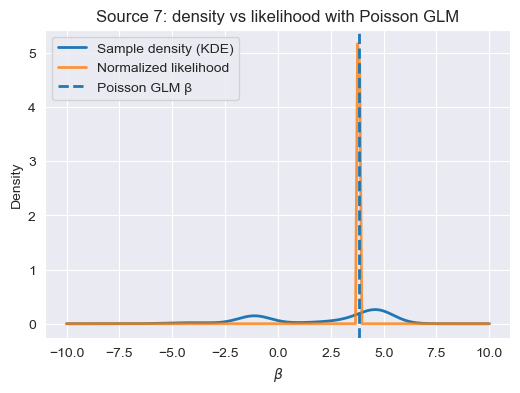

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.integrate import trapezoid
from scipy.special import gammaln
import statsmodels.api as sm

def simulate_profile_likelihoods_poisson(
    K: int = 5,
    S: int = 8,
    O: int = 8,
    n_obs: int = 100,
    *,
    beta_mean: np.ndarray | None = None,
    beta_sds:  np.ndarray | None = None,
    true_pis:  np.ndarray | None = None,
    grid:      np.ndarray | None = None,
    seed: int = 0,
):
    rng = np.random.default_rng(seed)
    if beta_mean is None:
        beta_mean = np.linspace(-1, 1, K)
    if beta_sds is None:
        beta_sds = np.full(K, 0.15)
    beta_mean = np.asarray(beta_mean, dtype=float)
    beta_sds  = np.asarray(beta_sds,  dtype=float)
    if beta_mean.shape != (K,) or beta_sds.shape != (K,):
        raise ValueError("beta_mean and beta_sds must be length-K arrays")
    if grid is None:
        raise ValueError("Provide a 1-D array of grid points via `grid`")
    grid = np.asarray(grid, dtype=float)
    if true_pis is None:
        true_pis = rng.dirichlet(np.ones(K) * 2.0, size=S)

    recs = []
    beta_recs = []
    X_list = []
    Y_list = []

    for s in range(S):
        pi_s = true_pis[s]
        for o in range(O):
            z      = rng.choice(K, size=n_obs, p=pi_s)
            beta_i = rng.normal(loc=beta_mean[z], scale=beta_sds[z])
            beta_recs.append({"source": s+1, "outcome": o+1, "beta_true": beta_i.copy()})
            x_i = rng.uniform(-1, 1, size=n_obs)
            lam = np.exp(beta_i * x_i)
            y_i = rng.poisson(lam)
            X_list.append({"source": s+1, "outcome": o+1, "x": x_i.copy()})
            Y_list.append({"source": s+1, "outcome": o+1, "y": y_i.copy()})
            for b in grid:
                logp = y_i * (b * x_i) - np.exp(b * x_i) - gammaln(y_i + 1)
                recs.append({"source": s+1, "outcome": o+1, "point": b, "value": logp.sum()})

    df_sim  = pd.DataFrame.from_records(recs)
    beta_df = pd.DataFrame.from_records(beta_recs)
    return df_sim, true_pis, beta_df, X_list, Y_list

def plot_source_density_vs_likelihood(
    s: int,
    df_sim: pd.DataFrame,
    beta_df: pd.DataFrame,
    X_list: list[dict],
    Y_list: list[dict],
    *,
    kde_bw: str | float | None = None,
    xgrid_len: int = 2000,
    ax: plt.Axes | None = None,
):
    # 1) subset for the requested source
    sim_sub = df_sim[df_sim["source"] == s]
    beta_raw = beta_df[beta_df["source"] == s]["beta_true"].to_numpy()
    if sim_sub.empty or beta_raw.size == 0:
        raise ValueError(f"No records found for source {s}")
    beta_list = [np.atleast_1d(entry) for entry in beta_raw]
    beta_sub = np.concatenate(beta_list).astype(float)

    # 2) flatten X and Y for Poisson regression
    x_all = np.concatenate([d["x"] for d in X_list if d["source"] == s])
    y_all = np.concatenate([d["y"] for d in Y_list if d["source"] == s])

    # 3) fit Poisson regression (no intercept): log(E[y]) = b * x
    model = sm.GLM(y_all, x_all[:, None], family=sm.families.Poisson())
    result = model.fit()
    b_est = result.params[0]

    # 4) KDE for β samples
    kde = gaussian_kde(beta_sub, bw_method=kde_bw)

    # 5) profile-likelihood → density
    g = sim_sub.groupby("point")["value"].sum().sort_index()
    x_lik = g.index.to_numpy()
    loglik = g.values - g.values.max()
    p_lik = np.exp(loglik)
    p_lik /= trapezoid(p_lik, x_lik)

    # 6) compute sample mean & profile MLE
    sample_mean = beta_sub.mean()
    mle = x_lik[np.argmax(p_lik)]

    print(f"Source {s}: sample mean = {sample_mean:.4f}, profile MLE = {mle:.4f}, Poisson GLM β = {b_est:.4f}")

    # 7) plot
    xmin = min(x_lik.min(), beta_sub.min())
    xmax = max(x_lik.max(), beta_sub.max())
    xgrid = np.linspace(xmin, xmax, xgrid_len)
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(xgrid, kde(xgrid), label="Sample density (KDE)", lw=2)
    ax.plot(x_lik, p_lik, label="Normalized likelihood", lw=2, alpha=0.8)
    ax.axvline(b_est, linestyle="--", label="Poisson GLM β", lw=2)
    ax.set_title(f"Source {s}: density vs likelihood with Poisson GLM")
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel("Density")
    ax.grid(True)
    ax.legend()
    return ax, beta_sub

# Example usage
rng = np.random.default_rng(42)
grid_pts = np.linspace(-10, 10, 200)
beta_mean = rng.normal(loc=2.0, scale=3.0, size=5)
beta_sds  = np.abs(rng.normal(loc=0.0, scale=1.0, size=5))

df_sim, true_pis, beta_df, X_list, Y_list = simulate_profile_likelihoods_poisson(
    K=5, S=8, O=8, n_obs=100,
    beta_mean=beta_mean,
    beta_sds=beta_sds,
    grid=grid_pts,
    seed=42
)

# Plot for source 1
ax, beta_sub = plot_source_density_vs_likelihood(7, df_sim, beta_df, X_list, Y_list)
plt.show()


Source 1: sample mean = 0.7600, profile MLE = 2.2613, Poisson GLM β = 2.3116
Source 2: sample mean = 2.0181, profile MLE = 3.7688, Poisson GLM β = 3.7447
Source 3: sample mean = 2.6213, profile MLE = 3.7688, Poisson GLM β = 3.7926
Source 4: sample mean = 2.5092, profile MLE = 3.9698, Poisson GLM β = 3.9740
Source 5: sample mean = 1.8655, profile MLE = 3.5678, Poisson GLM β = 3.5769
Source 6: sample mean = 1.9892, profile MLE = 3.7688, Poisson GLM β = 3.7698
Source 7: sample mean = 2.2631, profile MLE = 3.7688, Poisson GLM β = 3.8192
Source 8: sample mean = 1.1879, profile MLE = 3.2663, Poisson GLM β = 3.2435


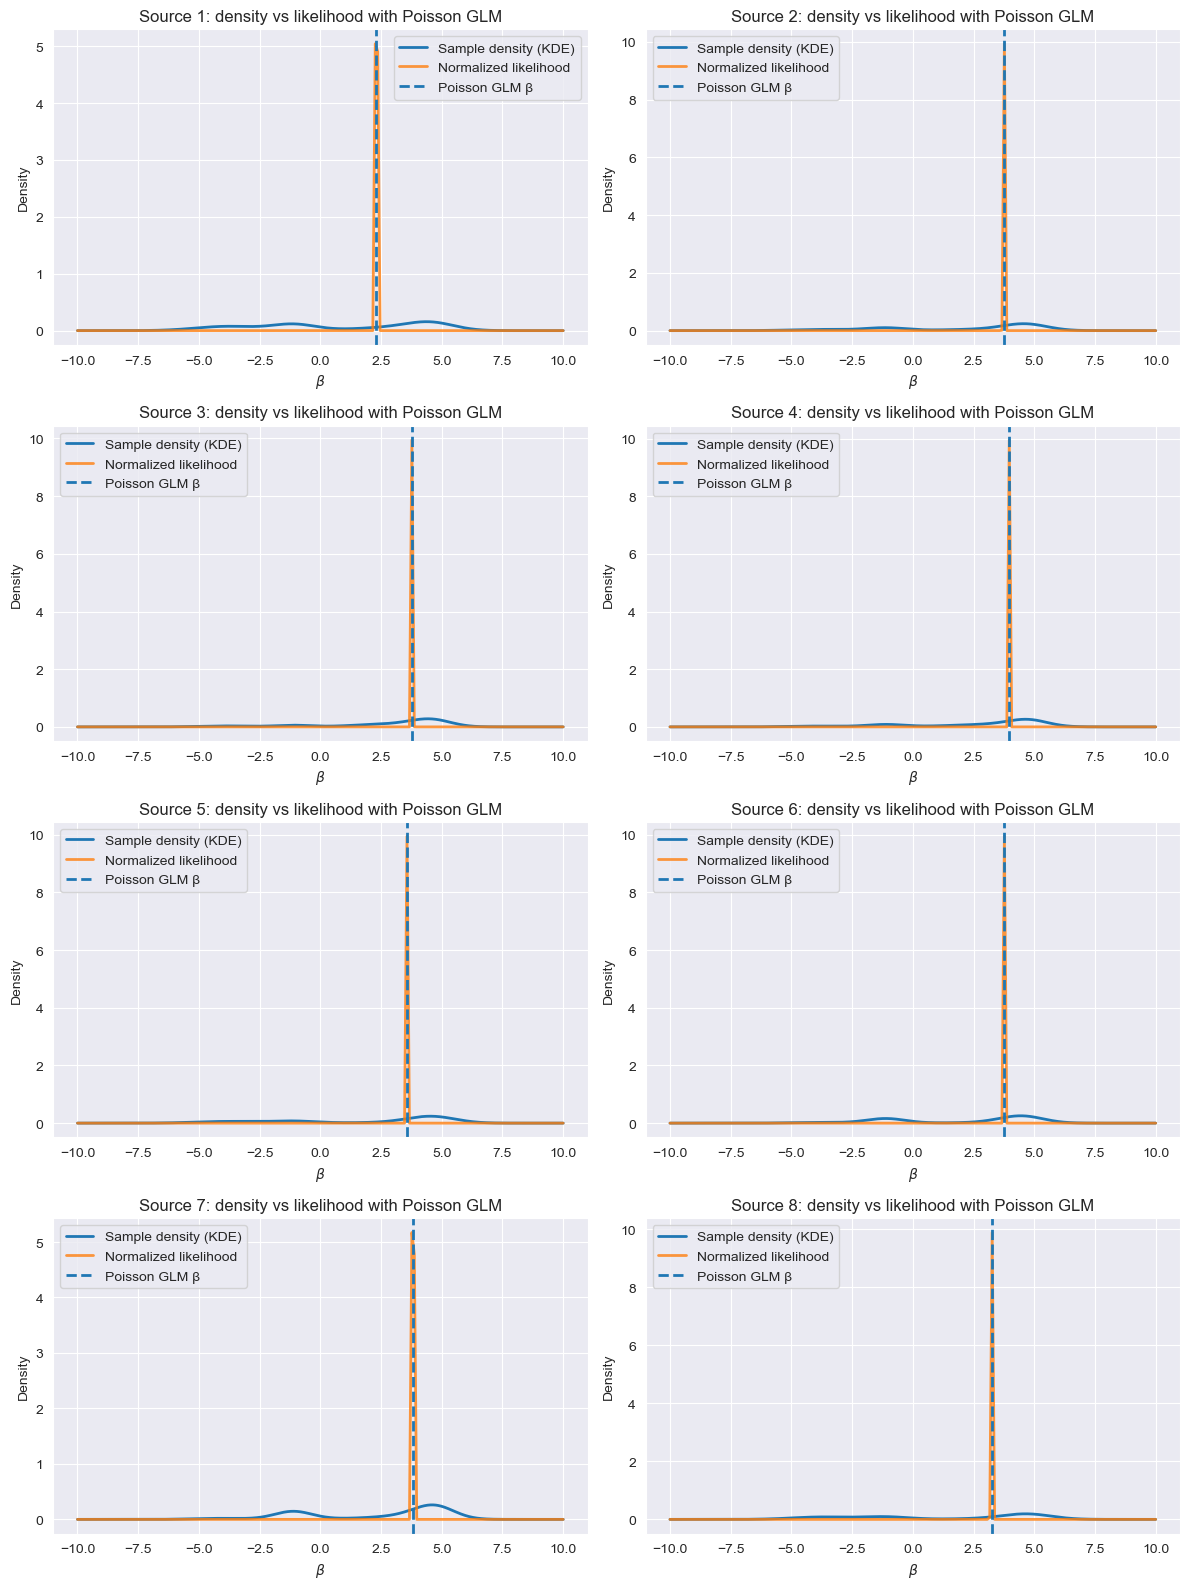

In [81]:
def plot_source_outcome_density_vs_likelihood(
    s: int,
    o: int,
    df_sim: pd.DataFrame,
    beta_df: pd.DataFrame,
    X_list: list[dict],
    Y_list: list[dict],
    *,
    kde_bw: str | float | None = None,
    xgrid_len: int = 2000,
    ax: plt.Axes | None = None,
):
    # filter for specific source & outcome
    sim_sub = df_sim[(df_sim["source"] == s) & (df_sim["outcome"] == o)]
    beta_raw = beta_df[(beta_df["source"] == s) & (beta_df["outcome"] == o)]["beta_true"].to_numpy()
    if sim_sub.empty or beta_raw.size == 0:
        raise ValueError(f"No records for source {s}, outcome {o}")

    # flatten beta vector
    beta_sub = np.atleast_1d(beta_raw[0]).astype(float)

    # flatten X and Y vectors
    x_all = np.atleast_1d([d["x"] for d in X_list if d["source"]==s and d["outcome"]==o][0]).astype(float)
    y_all = np.atleast_1d([d["y"] for d in Y_list if d["source"]==s and d["outcome"]==o][0]).astype(int)

    # fit Poisson regression (no intercept)
    model = sm.GLM(y_all, x_all[:, None], family=sm.families.Poisson())
    result = model.fit()
    b_est = result.params[0]

    # KDE density
    kde = gaussian_kde(beta_sub, bw_method=kde_bw)

    # profile-likelihood → density
    g = sim_sub.groupby("point")["value"].sum().sort_index()
    x_lik = g.index.to_numpy()
    loglik = g.values - g.values.max()
    p_lik = np.exp(loglik)
    p_lik /= trapezoid(p_lik, x_lik)

    # summary stats
    sample_mean = np.mean(beta_sub)
    mle = x_lik[np.argmax(p_lik)]
    print(f"Source {s}, Outcome {o}: mean={sample_mean:.4f}, MLE={mle:.4f}, GLM β={b_est:.4f}")

    # x-grid
    xmin, xmax = beta_sub.min(), beta_sub.max()
    xmin = min(xmin, x_lik.min())
    xmax = max(xmax, x_lik.max())
    xgrid = np.linspace(xmin, xmax, xgrid_len)

    # plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_xlim(-3, 3)
    ax.plot(xgrid, kde(xgrid), label="Sample density (KDE)", lw=2)
    ax.plot(x_lik, p_lik, label="Normalized likelihood", lw=2, alpha=0.8)
    ax.axvline(b_est, linestyle="--", label="Poisson GLM β", lw=2)
    ax.set_title(f"Source {s}, Outcome {o}: density vs. likelihood")
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel("Density")
    ax.grid(True)

    return ax

import math

# get sorted list of sources
sources = sorted(df_sim["source"].unique())
n_sources = len(sources)

#set up 2‐column grid
ncols = 2
nrows = math.ceil(n_sources / ncols)
fig, axes = plt.subplots(nrows, ncols,
                         figsize=(12, 4 * nrows),
                         sharex=False, sharey=False)

# flatten axes array for easy indexing
axes_flat = axes.flatten()

# loop over sources and plot
for ax, s in zip(axes_flat, sources):
    plot_source_density_vs_likelihood(s, df_sim, beta_df, X_list, Y_list, ax=ax)

# hide any unused subplots
for ax in axes_flat[n_sources:]:
    ax.set_visible(False)

fig.tight_layout()
plt.show()


In [4]:
K = 5
S = 8
O = 8
n_obs = 100
grid = grid_pts
seed = 42
rng = np.random.default_rng(seed)

if beta_mean is None:
    beta_mean = np.linspace(-1, 1, K)
if beta_sds is None:
    beta_sds = np.full(K, 0.15)
beta_mean = np.asarray(beta_mean, dtype=float)
beta_sds  = np.asarray(beta_sds,  dtype=float)
if beta_mean.shape != (K,) or beta_sds.shape != (K,):
    raise ValueError("beta_mean and beta_sds must be length-K arrays")
if grid is None:
    raise ValueError("Provide a 1-D array of grid points via `grid`")
grid = np.asarray(grid, dtype=float)
if true_pis is None:
    true_pis = rng.dirichlet(np.ones(K) * 2.0, size=S)

recs = []
beta_recs = []
X_list = []
Y_list = []

for s in range(S):
    pi_s = true_pis[s]
    for o in range(O):
        z      = rng.choice(K, size=n_obs, p=pi_s)
        beta_i = rng.normal(loc=beta_mean[z], scale=beta_sds[z])
        beta_recs.append({"source": s+1, "outcome": o+1, "beta_true": beta_i.copy()})
        x_i = rng.uniform(-1, 1, size=n_obs)
        lam = np.exp(beta_i * x_i)
        y_i = rng.poisson(lam)
        model = sm.GLM(y_i, x_i[:, None], family=sm.families.Poisson())
        result = model.fit()
        b_est = result.params[0]
        print(f"the estimated beta is {b_est:.4f}")
        print(f'sample mean is {np.mean(beta_i):.4f}')
        X_list.append({"source": s+1, "outcome": o+1, "x": x_i.copy()})
        Y_list.append({"source": s+1, "outcome": o+1, "y": y_i.copy()})
        for b in grid:
            logp = y_i * (b * x_i) - np.exp(b * x_i) - gammaln(y_i + 1)
            recs.append({"source": s+1, "outcome": o+1, "point": b, "value": logp.sum()})

df_sim  = pd.DataFrame.from_records(recs)
beta_df = pd.DataFrame.from_records(beta_recs)

x_i = X_list[0]["source"]


NameError: name 'sm' is not defined

## Linear regression

In [7]:
def simulate_profile_likelihoods_linreg(
    K: int = 5,
    S: int = 8,
    O: int = 8,
    n_obs: int = 100,
    *,
    beta_mean: np.ndarray | None = None,
    beta_sds:  np.ndarray | None = None,
    true_pis:  np.ndarray | None = None,
    grid: np.ndarray | None = None,
    sigma_noise: float = 1.0,
    seed: int = 0,
):
    """
    Linear-regression analogue to your Poisson simulator, now ALSO returning a
    table of the latent β actually used for every (source, outcome) pair,
    stored as a length-n_obs vector.
    """
    rng = np.random.default_rng(seed)

    # ── 1) component means / sds ──────────────────────────────────────────
    if beta_mean is None:
        beta_mean = np.linspace(-1, 1, K)
    if beta_sds is None:
        beta_sds = np.full(K, 0.15)
    beta_mean = np.asarray(beta_mean, dtype=float)
    beta_sds  = np.asarray(beta_sds,  dtype=float)
    if beta_mean.shape != (K,) or beta_sds.shape != (K,):
        raise ValueError("`beta_mean` and `beta_sds` must be length-K arrays")

    # ── 2) grid of candidate slopes ──────────────────────────────────────
    if grid is None:
        raise ValueError("Supply a 1-D array of grid points via `grid`.")
    grid = np.asarray(grid, dtype=float)

    # ── 3) Dirichlet weights per source ──────────────────────────────────
    if true_pis is None:
        true_pis = rng.dirichlet(np.full(K, 2.0), size=S)   # (S, K)

    # ── 4) simulate & profile-likelihood evaluation ─────────────────────
    const_term = -0.5 * n_obs * np.log(2 * np.pi * sigma_noise**2)

    recs      = []   # profile-likelihood rows
    beta_recs = []   # true β per (s,o), now as full vectors

    for s in range(S):                               # zero-based
        pi_s = true_pis[s]

        for o in range(O):                           # zero-based
            # 4-1) latent component + β for each observation
            z       = rng.choice(K, size=n_obs, p=pi_s)
            beta_i  = rng.normal(loc=beta_mean[z], scale=beta_sds[z])

            # ─ record the ENTIRE beta_i vector ─
            beta_recs.append({
                "source":    s + 1,
                "outcome":   o + 1,
                "beta_true": beta_i.copy()   # vector of length n_obs
            })

            # 4-2) covariate & response
            x_i = rng.uniform(-1, 1, size=n_obs)
            y_i = beta_i * x_i + rng.normal(0.0, sigma_noise, size=n_obs)

            # 4-3) profile log-likelihood over the grid
            for b in grid:
                resid_sq = (y_i - b * x_i) ** 2
                ll       = const_term - 0.5 * resid_sq.sum() / sigma_noise**2
                recs.append(
                    dict(source=s + 1, outcome=o + 1, point=b, value=ll)
                )

    df_sim  = pd.DataFrame.from_records(recs)
    beta_df = pd.DataFrame.from_records(beta_recs)

    return df_sim, true_pis, beta_df

grid_pts   = np.linspace(-10, 10, 100)
beta_mean  = rng.normal(loc=1.5, scale=0.7, size=5)
beta_sds = np.abs(rng.normal(loc=0.0, scale=1.0, size=5))

df_sim, pis, beta_df = simulate_profile_likelihoods_linreg(
    K=5, S=8, O=8, n_obs=120,
    beta_mean=beta_mean,
    beta_sds=beta_sds,
    sigma_noise=0.8,
    grid = grid_pts,
    seed=2025
)



## Logistic

In [6]:
def simulate_profile_likelihoods_logistic(
    K: int = 5,
    S: int = 8,
    O: int = 8,
    n_obs: int = 100,
    *,
    beta_mean: np.ndarray | None = None,
    beta_sds:  np.ndarray | None = None,
    true_pis:  np.ndarray | None = None,
    grid:      np.ndarray | None = None,
    seed: int = 0,
):
    """
    Simulate profile-likelihood curves for a K-component *logistic-regression*
    mixture and KEEP the full ground-truth β_i vector for every (source, outcome).
    """
    rng = np.random.default_rng(seed)

    # 1) component means / sds
    if beta_mean is None:
        beta_mean = np.linspace(-1, 1, K)
    if beta_sds is None:
        beta_sds = np.full(K, 0.15)
    beta_mean = np.asarray(beta_mean, dtype=float)
    beta_sds  = np.asarray(beta_sds,  dtype=float)
    if beta_mean.shape != (K,) or beta_sds.shape != (K,):
        raise ValueError("beta_mean and beta_sds must be length-K arrays")

    # 2) grid of candidate β values
    if grid is None:
        raise ValueError("Provide a 1-D array of grid points via `grid`")
    grid = np.asarray(grid, dtype=float)

    # 3) Dirichlet weights per source
    if true_pis is None:
        true_pis = rng.dirichlet(np.ones(K) * 2.0, size=S)    # (S, K)

    # 4) simulate & evaluate profile log-likelihoods
    recs      = []   # profile-likelihood rows
    beta_recs = []   # table of full beta_i vectors

    for s in range(S):                              # zero-based 0..S-1
        pi_s = true_pis[s]

        for o in range(O):                          # zero-based 0..O-1
            # 4-1) latent component & β draw per observation
            z       = rng.choice(K, size=n_obs, p=pi_s)
            beta_i  = rng.normal(loc=beta_mean[z], scale=beta_sds[z])

            # ─ record the ENTIRE beta_i vector ─
            beta_recs.append({
                "source":    s + 1,
                "outcome":   o + 1,
                "beta_true": beta_i.copy()   # array of length n_obs
            })

            # 4-2) covariate & Bernoulli responses
            x_i     = rng.uniform(-1, 1, size=n_obs)
            logit_p = beta_i * x_i
            p_i     = 1.0 / (1.0 + np.exp(-logit_p))
            y_i     = rng.binomial(1, p_i)

            # 4-3) profile log-likelihood over the grid
            for b in grid:
                bx   = b * x_i
                ll   = (y_i * bx - np.log1p(np.exp(bx))).sum()
                recs.append(
                    dict(source=s + 1, outcome=o + 1, point=b, value=ll)
                )

    df_sim  = pd.DataFrame.from_records(recs)
    beta_df = pd.DataFrame.from_records(beta_recs)
    return df_sim, true_pis, beta_df

rng = np.random.default_rng(42)

grid_pts  = np.linspace(-10, 10, 100)
beta_mean = rng.normal(loc=2.0,  scale=3.0, size=5)
beta_sds  = np.abs(rng.normal(loc=0.0, scale=1.0, size=5))

df_sim, true_pis, beta_df = simulate_profile_likelihoods_logistic(
    K=5, S=8, O=8, n_obs=1000,
    beta_mean=beta_mean,
    beta_sds=beta_sds,
    grid=grid_pts,
    seed=42
)

In [170]:
N_sources = 8
source_outcome_data = {}
for s in range(1, N_sources+1):
    df_s = df_sim[df_sim["source"]==s]
    outcome_list = []
    for o in sorted(df_s["outcome"].unique()):
        arr = df_s[df_s["outcome"]==o][["point","value"]].to_numpy()
        outcome_list.append(jnp.array(arr))
    source_outcome_data[s] = outcome_list

num_outcomes_dict = {s: len(source_outcome_data[s])
                     for s in range(2, N_sources+1)}

In [12]:
# --- keep your helper functions ------------------------------------------------
def stick_breaking(beta):
    portion_remaining = jnp.concatenate(
        [jnp.array([1.]), jnp.cumprod(1. - beta)[:-1]]
    )
    return beta * portion_remaining


def reparameterize(pi):
    return pi / pi.sum()

def custom_loglike(beta, outcome_data_list):
    total_ll = 0.
    for outcome_data in outcome_data_list:
        x_vals = outcome_data[:,0]
        loglike_vals = outcome_data[:,1]
        total_ll += jnp.interp(beta, x_vals, loglike_vals)
    return total_ll


def HDP_model(source_outcome_data,
              num_outcomes_dict,
              N_sources,
              k,
              data_point_mean):
    # 1) Top‐level concentrations
    gamma  = numpyro.sample("gamma",  dist.Gamma(1.0, 5.0))
    alpha0 = numpyro.sample("alpha0", dist.Gamma(1.0, 5.0))

    # 2) Global stick‐breaking
    beta_tilt = numpyro.sample("beta_tilt",
                               dist.Beta(1.0, gamma).expand([k]))
    beta      = stick_breaking(beta_tilt)
    numpyro.deterministic("beta", beta)

    # 3) Source‐specific sticks & normalization
    pi_tilt = numpyro.sample(
        "pi_tilt",
        dist.Beta(alpha0 * beta, alpha0 * (1.0 - jnp.cumsum(beta)))
            .expand([N_sources, k])
    )
    pi_norm = jax.vmap(lambda row: reparameterize(stick_breaking(row)))(
        pi_tilt
    )
    numpyro.deterministic("pi_norm", pi_norm)

    # 4) Shared component parameters
    mu    = numpyro.sample("mu",    dist.Normal(0.0, 10.0).expand([k]))
    sigma = numpyro.sample("sigma", dist.HalfNormal(10.0).expand([k]))

    # 5) For each source, draw its β_j from the mixture directly
    for s in range(1, N_sources+1):
        beta_s = numpyro.sample(
            f"beta_{s}",
            dist.MixtureSameFamily(
                dist.Categorical(probs=pi_norm[s-1]),
                dist.Normal(mu, sigma),
            )
        )
        numpyro.factor(
            f"loglike_{s}",
            custom_loglike(beta_s, source_outcome_data[s])
        )
    # )

# end of model


In [ ]:
# 5) Run MCMC just as before
rng_key = random.PRNGKey(0)
data_point_mean = df_sim["point"].mean()
k = 5

nuts = NUTS(HDP_model)
mcmc = MCMC(nuts, num_warmup=5000, num_samples=20000)
mcmc.run(
    rng_key,
    source_outcome_data=source_outcome_data,
    num_outcomes_dict=num_outcomes_dict,
    N_sources=N_sources,
    k=k,
    data_point_mean=data_point_mean
)

mcmc.print_summary()
idata = az.from_numpyro(mcmc)

In [8]:
def compute_g0_components(idata, output_path, xgrid_len=200):
    """
    Compute and save posterior components for G₀:
      - xgrid: evaluation points
      - g0: posterior mean density values
      - mu, sigma: component parameters per sample
      - pi_norm, alpha0, zeta: mixture weights per sample

    Saves a .npz file at output_path with these arrays.
    """
    if output_path is None:
        os.makedirs(output_path, exist_ok=True)
    # 1) Extract posterior arrays
    post = idata.posterior
    pi_norm_vals = post["pi_norm"].values    # (chains, draws, sources, components)
    alpha0_vals  = post["alpha0"].values     # (chains, draws)
    mu_vals      = post["mu"].values         # (chains, draws, components)
    sigma_vals   = post["sigma"].values      # (chains, draws, components)

    # 2) Reshape into (n_samples, sources, components) and (n_samples, components)
    n_chains, n_draws, N_sources, k = pi_norm_vals.shape
    n_samples = n_chains * n_draws
    pi_norm = pi_norm_vals.reshape(n_samples, N_sources, k)
    alpha0  = alpha0_vals.reshape(n_samples)
    mu      = mu_vals.reshape(n_samples, k)
    sigma   = sigma_vals.reshape(n_samples, k)

    # 3) Sample discrete assignments z_j per sample (vectorized)
    unif   = np.random.rand(n_samples, N_sources)
    cum_pi = np.cumsum(pi_norm, axis=2)
    z_samp = (unif[..., None] < cum_pi).argmax(axis=2)

    # 4) Component counts per sample
    m_samps = np.array([np.bincount(z_samp[i], minlength=k)
                        for i in range(n_samples)])  # (n_samples, k)

    # 5) Expected global weights ζ_h per sample
    zeta = (m_samps + alpha0[:, None] / k) \
         / (m_samps.sum(axis=1)[:, None] + alpha0[:, None])  # (n_samples, k)

    # 6) Build evaluation grid
    x_min = mu.min() - 3 * sigma.max()
    x_max = mu.max() + 3 * sigma.max()
    xgrid = np.linspace(x_min, x_max, xgrid_len)

    # 7) Compute posterior mean G₀ density
    g0 = np.zeros_like(xgrid)
    for i in range(n_samples):
        for h in range(k):
            coef = zeta[i, h]
            pdf = (1.0 / (np.sqrt(2 * np.pi) * sigma[i, h])) * \
                  np.exp(-0.5 * ((xgrid - mu[i, h]) / sigma[i, h])**2)
            g0 += coef * pdf
    g0 /= n_samples

    # 8) Save all arrays to .npz
    np.savez(output_path,
             xgrid=xgrid,
             g0=g0,
             mu=mu,
             sigma=sigma,
             pi_norm=pi_norm,
             alpha0=alpha0,
             zeta=zeta)

def plot_g0_density_from_file(npz_path, density_cut, save_to=None):
    """
    Load G₀ components from a .npz file and plot the posterior mean density,
    masking out regions where the density ≤ density_cut.
    """
    data = np.load(npz_path)
    xgrid = data["xgrid"]
    g0     = data["g0"]

    mask = g0 > density_cut
    if not mask.any():
        raise ValueError(f"No points exceed density_cut={density_cut}")

    plt.figure(figsize=(8, 4))
    plt.plot(xgrid[mask], g0[mask])
    plt.title(r"Posterior Mean of $G_0$ Density")
    plt.xlabel(r"$x$")
    plt.ylabel(r"Density of $G_0$")
    if save_to:
        plt.savefig(save_to, dpi=300, bbox_inches="tight")
        plt.close()
    else:
        plt.show()


In [ ]:
compute_g0_components(idata, "results/g0_archives/g0_components.npz", xgrid_len=2000)
plot_g0_density_from_file("results/g0_archives/g0_components.npz", density_cut=1e-2)

In [145]:
beta_store = store_beta_posteriors(
    idata=idata,
    df_sim=df_sim,
    output_folder="results/beta_archives",
    file_ext="npz",      # or "npy"
    compress=True,
)

beta_data = load_beta_posteriors(
    folder="results/beta_archives",
    file_ext="npz",     # or "npy" if you saved .npy files
)

# Access arrays for source 3
b3 = beta_data["beta_3"]
samples_b3 = b3["samples"]
grid_b3    = b3["grid"]
loglik_b3  = b3["loglik"]
prior_samples_b3 = b3["prior_samples"] if "prior_samples" in b3 else np.array([])

best_per_source = largest_mean_pi_norm(idata, pis=pis)  # if you have one

for rec in best_per_source:
    print(
        f"Source {rec['source']:>2}: "
        f"best component={rec['component']:>2}, "
        f"mean π={rec['mean_value']:.3f}, "
        f"true max π={rec['true_proportion']:.3f}"
    )

Stored 8 β posteriors in results\beta_archives
Loaded 8 β posterior archives from results\beta_archives
Source  0: best component= 0, mean π=0.813, true max π=0.562
Source  1: best component= 0, mean π=0.814, true max π=0.402
Source  2: best component= 0, mean π=0.762, true max π=0.457
Source  3: best component= 0, mean π=0.818, true max π=0.308
Source  4: best component= 0, mean π=0.821, true max π=0.286
Source  5: best component= 0, mean π=0.821, true max π=0.399
Source  6: best component= 0, mean π=0.818, true max π=0.307
Source  7: best component= 0, mean π=0.822, true max π=0.358


In [142]:
save_beta_density_hist(
    idata,
    output_folder="figures/beta_plots",
    experiment="sim1",          # will create sim1_beta_0.jpg, …
)

Saved experiment sim1 beta densities to figures\beta_plots


In [9]:
def plot_df_prior_vs_posterior(
    idata,
    beta_df,
    *,
    kde_bw: str | float | None = None,   # gaussian_kde bandwidth
    density_cut: float = 1e-2,           # trim x-axis where both dens < cut
    xgrid_len: int = 2_000,
    save_to: str | Path | None = None,
):
    """
    Overlay prior and posterior densities for every β_s found in *idata*,
    using the new beta_df where 'beta_true' is a vector per (source, outcome).

    Parameters
    ----------
    idata : arviz.InferenceData
        Must contain variables beta_<s>.
    beta_df : pandas.DataFrame
        Must contain columns ['source','outcome','beta_true'], where 'beta_true'
        is an array of latent β draws for each row.
    kde_bw : str | float | None
        Bandwidth for gaussian_kde.
    density_cut : float
        Trim x-axis where both prior & posterior density <= density_cut.
    xgrid_len : int
        Number of points in the evaluation grid.
    save_to : str | Path | None
        Path (including filename) where the figure will be saved.
    """

    # 1) Build prior_samples: concatenate all beta_true vectors per source
    prior_samples = {
        s: np.concatenate(group['beta_true'].to_list())
        for s, group in beta_df.groupby("source")
    }

    # 2) Locate posterior β variables and available sources
    beta_vars = [
        v for v in idata.posterior.data_vars
        if re.fullmatch(r"beta_\d+", v)
    ]
    sources_avl = sorted(int(v.split("_")[1]) for v in beta_vars)
    if not sources_avl:
        raise ValueError("No beta_* variables found in idata.posterior")

    # 3) Compute KDEs and sample ranges
    prior_kde = {}
    post_kde = {}
    sample_rng = {}
    for s in sources_avl:
        if s not in prior_samples:
            raise KeyError(f"Missing prior samples for source {s}")
        prior_draws = np.asarray(prior_samples[s]).ravel()
        prior_kde[s] = gaussian_kde(prior_draws, bw_method=kde_bw)

        post_draws = idata.posterior[f"beta_{s}"].values.ravel()
        post_kde[s] = gaussian_kde(post_draws, bw_method=kde_bw)

        sample_rng[s] = (
            min(prior_draws.min(), post_draws.min()),
            max(prior_draws.max(), post_draws.max())
        )

    # 4) Plotting setup
    n = len(sources_avl)
    ncols = 2
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 4 * nrows))
    axes = axes.flatten()

    # 5) Plot each source
    for idx, s in enumerate(sources_avl):
        xmin, xmax = sample_rng[s]
        xgrid = np.linspace(xmin, xmax, xgrid_len)

        p_prior = prior_kde[s](xgrid)
        p_post = post_kde[s](xgrid)

        # Trim x-axis
        mask = np.maximum(p_prior, p_post) > density_cut
        if mask.any():
            axes[idx].set_xlim(xgrid[mask].min(), xgrid[mask].max())

        axes[idx].plot(xgrid, p_prior, label="Prior (KDE)")
        axes[idx].plot(xgrid, p_post, label="Posterior (KDE)")
        axes[idx].set_title(f"Source {s}")
        axes[idx].set_xlabel(rf"$\beta_{{{s}}}$")
        axes[idx].set_ylabel("Density")
        axes[idx].grid(True)
        axes[idx].legend()

    # Turn off unused axes
    for ax in axes[n:]:
        ax.axis("off")

    fig.tight_layout()
    if save_to:
        fig.savefig(save_to, dpi=300, bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()

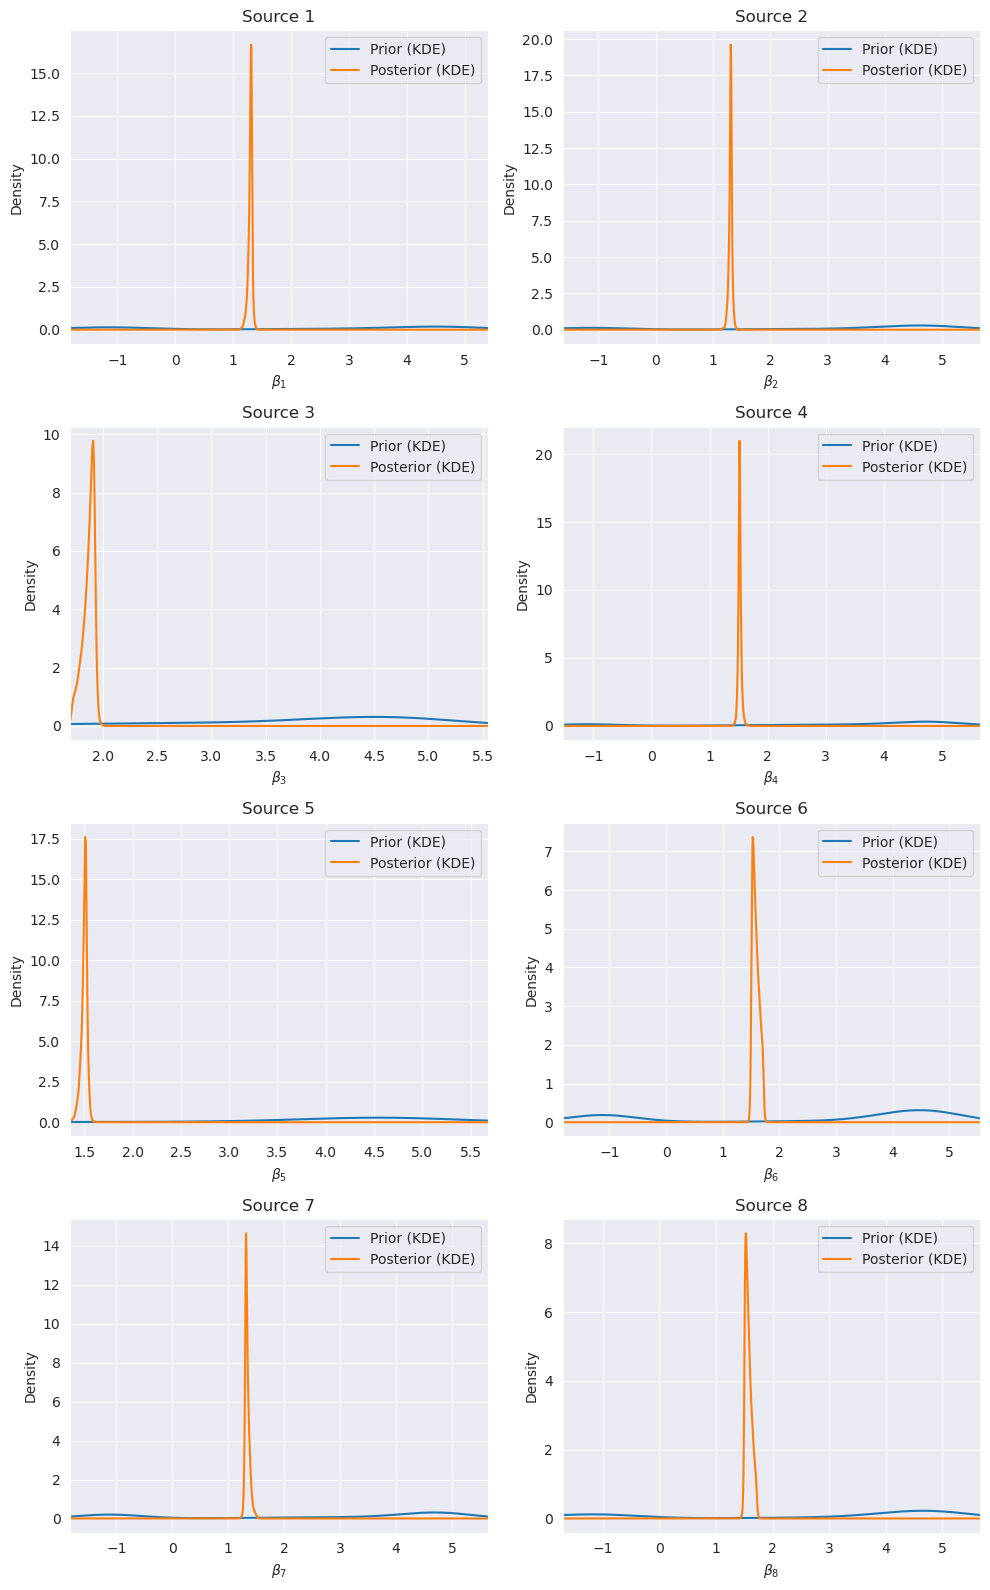

In [152]:
plot_df_prior_vs_posterior(idata, beta_df, kde_bw=0.2, density_cut=1e-1, save_to = "results")

In [16]:
def kl_prior_posterior_beta(
    idata,
    beta_df: pd.DataFrame,
    *,
    posterior_bins: int = 200,
    eps: float = 1e-12,
):
    """
    KL(posterior || prior) for each beta_s using Monte Carlo draws.

    Now handles beta_df where 'beta_true' is a vector per row.
    """
    # 1) Build prior_samples by concatenating beta_true vectors per source
    prior_samples = {
        source: np.concatenate(group["beta_true"].to_list())
        for source, group in beta_df.groupby("source")
    }

    # 2) Identify posterior beta variables
    beta_vars = [
        v for v in idata.posterior.data_vars
        if re.fullmatch(r"beta_\d+", v)
    ]
    sources_avl = sorted(int(v.split("_")[1]) for v in beta_vars)
    if not sources_avl:
        raise ValueError("No beta_* variables found in idata.posterior")

    kl_dict = {}
    for s in sources_avl:
        if s not in prior_samples:
            raise KeyError(f"Missing prior samples for source {s}")

        # Monte Carlo draws
        prior_draws = prior_samples[s]
        post_draws  = idata.posterior[f"beta_{s}"].values.ravel()

        # Shared histogram grid
        xmin = min(prior_draws.min(), post_draws.min())
        xmax = max(prior_draws.max(), post_draws.max())
        edges = np.linspace(xmin, xmax, posterior_bins + 1)
        widths = np.diff(edges)

        # Density estimation via histogram (normalized)
        prior_hist, _ = np.histogram(prior_draws, bins=edges, density=True)
        post_hist, _  = np.histogram(post_draws,  bins=edges, density=True)

        # KL divergence ∑ p_post * log(p_post/p_prior) * Δx
        p_post  = post_hist  + eps
        p_prior = prior_hist + eps
        kl_val = np.sum(widths * p_post * np.log(p_post / p_prior))
        kl_dict[s] = kl_val

    return kl_dict

In [17]:
kl_vals = kl_prior_posterior_beta(idata, beta_df)
for s, kl in kl_vals.items():
    print(f"Source {s}: KL(posterior‖prior) = {kl:0.4f}")

NameError: name 'idata' is not defined

In [19]:
def summarise_beta_prior_posterior(
    idata,
    beta_df: pd.DataFrame,
    *,
    kl_dict: dict[int, float] | None = None,
    experiment_label: int | str = 1,
):
    """
    Summarise PRIOR vs POSTERIOR for each β_s.

    Parameters
    ----------
    idata : arviz.InferenceData
        Must contain posterior variables named beta_<s>.
    beta_df : pd.DataFrame
        Must contain columns ['source','outcome','beta_true'], where 'beta_true'
        is an array of latent β draws for each row.
    kl_dict : dict {source → KL divergence}, optional
        Precomputed KL divergences.
    experiment_label : hashable
        Label for the experiment (goes in the "experiment" column).

    Returns
    -------
    stats_df : pandas.DataFrame
        Columns:
            experiment, source,
            prior_mean, prior_median,
            post_mean, post_median,
            mean_error, median_error,
            kl_divergence,
            post_ci_lower, post_ci_upper,
            ci_covers_prior_mean
    """
    # 1) Build prior_samples by concatenating every beta_true vector per source
    prior_samples = {
        s: np.concatenate(group["beta_true"].to_list())
        for s, group in beta_df.groupby("source")
    }

    # 2) Locate β_s in the posterior
    beta_vars = [
        v for v in idata.posterior.data_vars
        if re.fullmatch(r"beta_\d+", v)
    ]
    sources_avl = sorted(int(v.split("_")[1]) for v in beta_vars)
    if not sources_avl:
        raise ValueError("No beta_* variables found in idata.posterior")

    kl_dict = kl_dict or {}
    records = []

    # 3) Summarize each source
    for s in sources_avl:
        if s not in prior_samples:
            raise KeyError(f"Missing prior samples for source {s}")

        # Prior statistics
        prior_draws = prior_samples[s]
        prior_mean = float(prior_draws.mean())
        prior_median = float(np.median(prior_draws))

        # Posterior statistics
        post_draws = idata.posterior[f"beta_{s}"].values.ravel()
        post_mean = float(post_draws.mean())
        post_median = float(np.median(post_draws))
        ci_lower, ci_upper = np.percentile(post_draws, [2.5, 97.5])

        # Record
        records.append({
            "experiment": experiment_label,
            "source":     s,
            "prior_mean": prior_mean,
            "prior_median": prior_median,
            "post_mean": post_mean,
            "post_median": post_median,
            "mean_error": prior_mean - post_mean,
            "median_error": prior_median - post_median,
            "kl_divergence": kl_dict.get(s, np.nan),
            "post_ci_lower": ci_lower,
            "post_ci_upper": ci_upper,
            "ci_covers_prior_mean": ci_lower <= prior_mean <= ci_upper,
        })

    return pd.DataFrame.from_records(records)

In [180]:
stats = summarise_beta_prior_posterior(
    idata, beta_df,
    kl_dict=kl_vals,
    experiment_label=f"rep1"
)
largest_info = largest_mean_pi_norm(idata, pis=pis)
largest_df   = (
    pd.DataFrame(largest_info)
      .rename(columns={
          "component":      "largest_component",
          "mean_value":     "mean_pi_norm",
          "true_proportion":"true_max_pi",
          "source":         "src_zero",  # note: here source is zero-based
      })
)

# create zero-based key directly
stats["src_zero"] = stats["source"] - 1

# merge on src_zero
stats = (
    stats
      .merge(largest_df, on="src_zero", how="left")
      .drop(columns="src_zero")
)



In [ ]:
def run_hdp_experiments(
    K: int,
    O: int,
    S: int,
    n_obs: int,
    N_sources: int,
    seed: int,
    output_base: str,
    *,
    num_warmup: int = 5000,
    num_samples: int = 20000,
    n_reps: int = 10,                 # ← how many repetitions (k times)
):
    """
    Run the complete HDP simulation / fitting experiment `n_reps` times for
    *each* of the three data-generating families: linear, Poisson, logistic.

    All artefacts are written beneath

        {output_base}/{model_type}/

    where `model_type` ∈ {"linear","poisson","logistic"}.
    A single CSV containing the concatenated summary statistics is produced
    for every model family.

    Parameters
    ----------
    K, O, S, n_obs
        Mixture, outcome & observation sizes to pass through to your
        simulate_profile_likelihoods_* helpers.
    N_sources
        Preset number of sources in the HDP.
    seed
        Global seed.  Repetition-specific seeds are derived from it so that no
        two repetitions ever share the same random stream.
    output_base
        Root directory in which all results will be stored.
    num_warmup, num_samples
        Sampler settings for the NUTS-based MCMC.
    n_reps
        Number of repetitions **per model family**.
    """

    today_str = date.today().isoformat()
    rng_master = np.random.default_rng(seed)

    # Map each model family to its simulator helper ---------------------------
    sim_fns = dict(
        #linear   = simulate_profile_likelihoods_linreg,
        #poisson  = simulate_profile_likelihoods_poisson,
        logistic = simulate_profile_likelihoods_logistic,
    )

    for model_type, sim_fn in sim_fns.items():
        model_dir = Path(output_base) / model_type
        fig_dir   = model_dir / "figures" / "beta_plots"
        data_dir  = model_dir / "data"
        fig_dir.mkdir(parents=True, exist_ok=True)

        stats_all   = []   # collects one DF per repetition
        kl_all      = []
        proportion_largest = []

        for rep in range(30, n_reps + 1):
            # ----------------------------------------------------------------
            # 1)  Data generation
            # ----------------------------------------------------------------
            rep_seed = rng_master.integers(seed+rep)
            rng_rep  = np.random.default_rng(rep_seed)

            grid_pts  = np.linspace(-10, 10, 100)
            beta_mean = rng_rep.normal(loc=1.5, scale=0.7, size=K)
            beta_sds  = np.abs(rng_rep.normal(loc=0.0, scale=1.0, size=K))

            # Simulator may have family-specific keyword parameters.
            sim_kwargs = dict(
                K=K, S=S, O=O, n_obs=n_obs,
                beta_mean=beta_mean,
                beta_sds=beta_sds,
                grid=grid_pts,
                seed=rep_seed,
            )
            if model_type == "linear":
                sim_kwargs["sigma_noise"] = 0.8
            if model_type == "logistic":
                sim_kwargs["n_obs"] = 1000

            df_sim, pis_true, df_betas = sim_fn(**sim_kwargs)

            # ----------------------------------------------------------------
            # 2)  Reshape into source-outcome dict expected by HDP_model
            # ----------------------------------------------------------------
            source_outcome_data = {}
            for s in range(1, N_sources + 1):
                df_s = df_sim[df_sim["source"] == s]
                outcome_list = []
                for o in sorted(df_s["outcome"].unique()):
                    arr = df_s[df_s["outcome"] == o][["point", "value"]].to_numpy()
                    outcome_list.append(jnp.array(arr))
                source_outcome_data[s] = outcome_list

            num_outcomes_dict = {s: len(source_outcome_data[s])
                                 for s in range(1, N_sources + 1)}

            # ----------------------------------------------------------------
            # 3)  Run HDP
            # ----------------------------------------------------------------
            rng_key = random.PRNGKey(rep_seed)
            data_point_mean = df_sim["point"].mean()

            nuts_kernel = NUTS(HDP_model)
            mcmc = MCMC(nuts_kernel, num_warmup=num_warmup, num_samples=num_samples)
            mcmc.run(
                rng_key,
                source_outcome_data=source_outcome_data,
                num_outcomes_dict=num_outcomes_dict,
                N_sources=N_sources,
                k=K,
                data_point_mean=data_point_mean,
            )
            idata = az.from_numpyro(mcmc)

            store_beta_posteriors(
                idata=idata,
                df_sim=df_sim,
                beta_df=df_betas,
                output_folder=data_dir/f"rep{rep}",
                file_ext="npz",      # or "npy"
                compress=True,
            )

            # ----------------------------------------------------------------
            # 4)  Save betas density histograms
            # ----------------------------------------------------------------
            save_beta_density_hist(
                idata,
                output_folder=str(fig_dir),
                experiment=f"rep{rep}",
            )

            # ----------------------------------------------------------------
            # 5)  Save PPC (prior vs posterior) comparison
            # ----------------------------------------------------------------
            ppc_path = model_dir / f"rep{rep}_ppc.png"
            ppc_obj  = plot_df_prior_vs_posterior(idata, df_betas, save_to=ppc_path)


            if isinstance(ppc_obj, plt.Figure):           # helper returns a Figure
                ppc_obj.savefig(ppc_path, dpi=300, bbox_inches="tight")
                plt.close(ppc_obj)

            elif hasattr(ppc_obj, "figure"):              # helper returns an Axes
                ppc_obj.figure.savefig(ppc_path, dpi=300, bbox_inches="tight")
                plt.close(ppc_obj.figure)

            else:
                # Helper already saved the plot (or user doesn’t need a file).
                # If you still want confirmation:
                print(f"  [info] plot_df_prior_vs_posterior returned {type(ppc_obj)}; "
                      "skipping explicit save.")

            # ----------------------------------------------------------------
            # 6)  KL divergence
            # ----------------------------------------------------------------
            kl_vals = kl_prior_posterior_beta(idata, beta_df=df_betas)
            kl_vals["rep"] = rep          # keep track of repetition
            kl_all.append(kl_vals)

            # ----------------------------------------------------------------
            # 7)  Summary statistics
            # ----------------------------------------------------------------
            stats = summarise_beta_prior_posterior(idata, df_betas, kl_dict=kl_vals, experiment_label=f"rep{rep}")
            largest_info = largest_mean_pi_norm(idata, pis=pis)
            largest_df   = pd.DataFrame(largest_info).rename(columns={
                "component":      "largest_component",
                "mean_value":     "mean_pi_norm",
                "true_proportion":"true_max_pi",
                "source":         "src_zero",
            })

            # 3 ── create the join key in *stats*  (convert “beta1” → 0, “beta2” → 1, …)
            stats["src_zero"] = stats["source"] - 1

            # 4 ── merge and drop helper key
            stats = (
                stats
                  .merge(largest_df, on="src_zero", how="left")
                  .drop(columns="src_zero")
            )
            stats_all.append(stats)
            # compute and store G0 components

            g0_path = data_dir/f"rep{rep}"/ "g0_components.npz"
            compute_g0_components(idata, output_path=str(g0_path), xgrid_len=2000)

            # plot and save mean G0 density
            g0_fig = fig_dir / f"rep{rep}_g0.png"
            plot_g0_density_from_file(npz_path=str(g0_path), density_cut=1e-2, save_to=str(g0_fig))

            print(f"[{model_type}] repetition {rep} finished.")

        # --------------------------------------------------------------------
        #  Persist concatenated results for this model family
        # --------------------------------------------------------------------
        stats_df = pd.concat(stats_all, ignore_index=True)
        fname = model_dir / f"beta_summary_stats.csv"
        stats_df.to_csv(fname, index=False)


        print(f"\nCompleted all {n_reps} repetitions for '{model_type}'. "
              f"Results stored in: {model_dir}\n")

# Example run:
today_str = date.today().isoformat()
run_hdp_experiments(
    K=5, O=8, S=8, n_obs=120,
    N_sources=8,
    seed=42,
    output_base=f"results_sample_{today_str}",
    num_warmup=5000,
    num_samples=20000,
    n_reps=100
)


In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.genmod import families
from pathlib import Path

def load_and_augment_results(
    results_base: str,
    seed: int,
    K: int,
    O: int,
    S: int,
    n_obs: int,
    model_types=None,
    prior_bins: int = 200
) -> pd.DataFrame:
    """
    Load results, compute prior mode and CI coverage, and reconstruct raw data
    per source to fit a GLM and estimate beta via statsmodels.
    """
    results_base = Path(results_base)
    if model_types is None:
        model_types = [p.name for p in results_base.iterdir() if p.is_dir()]

    all_stats = []
    for model in model_types:
        model_dir = results_base / model
        stats_path = model_dir / "beta_summary_stats.csv"
        if not stats_path.exists():
            continue
        stats = pd.read_csv(stats_path)

        # Determine rep seeds
        reps = sorted(int(str(e).lstrip("rep")) for e in stats["experiment"].unique())
        rng_master = np.random.default_rng(seed)
        rep_seeds = {rep: rng_master.integers(seed + rep) for rep in reps}

        # Prepare new columns
        stats["prior_mode"] = np.nan
        stats["covers_prior_median"] = False
        stats["covers_prior_mode"] = False
        stats["glm_beta_est"] = np.nan

        for idx, row in stats.iterrows():
            rep = int(str(row["experiment"]).lstrip("rep"))
            rep_seed = rep_seeds[rep]

            # Reconstruct hyperparameters
            rng_rep = np.random.default_rng(rep_seed)
            beta_mean = rng_rep.normal(loc=1.5, scale=0.7, size=K)
            beta_sds  = np.abs(rng_rep.normal(loc=0.0, scale=1.0, size=K))

            # Simulate raw data
            rng = np.random.default_rng(rep_seed)
            true_pis = rng.dirichlet(np.ones(K)*2.0, size=S)

            xs, ys, srcs = [], [], []
            for s in range(1, S+1):
                pi_s = true_pis[s-1]
                for _ in range(O):
                    z     = rng.choice(K, size=n_obs, p=pi_s)
                    beta_i = rng.normal(loc=beta_mean[z], scale=beta_sds[z])
                    x_i   = rng.uniform(-1, 1, size=n_obs)
                    if model == "poisson":
                        lam = np.exp(beta_i * x_i)
                        y_i = rng.poisson(lam)
                    elif model == "logistic":
                        logits = beta_i * x_i
                        p_i    = 1.0 / (1.0 + np.exp(-logits))
                        y_i = rng.binomial(1, p_i)
                    else:  # linear
                        y_i = beta_i * x_i + rng.normal(0, 0.8, size=n_obs)

                    xs.append(x_i)
                    ys.append(y_i)
                    srcs.append(np.full(n_obs, s))

            xs = np.concatenate(xs)
            ys = np.concatenate(ys)
            srcs = np.concatenate(srcs)
            df_raw = pd.DataFrame({"source": srcs, "x": xs, "y": ys})

            # Fit GLM for this source
            df_s = df_raw[df_raw["source"] == row["source"]]
            X = sm.add_constant(df_s["x"])
            if model == "poisson":
                fam = families.Poisson()
            elif model == "logistic":
                fam = families.Binomial()
            else:
                fam = families.Gaussian()
            glm_res = sm.GLM(df_s["y"], X, family=fam).fit(disp=False)
            stats.at[idx, "glm_beta_est"] = glm_res.params.get("x", np.nan)

            # Load posterior/prior bundle with pickle allowed
            npz_path = model_dir / "data" / f"rep{rep}" / f"beta_{row['source']}.npz"
            if npz_path.exists():
                bundle = np.load(npz_path, allow_pickle=True)
                raw_prior = bundle["prior_samples"]
                # flatten object array of arrays
                if raw_prior.dtype == object:
                    prior_samps = np.concatenate(raw_prior)
                else:
                    prior_samps = raw_prior

                # Compute prior mode via histogram
                counts, edges = np.histogram(prior_samps, bins=prior_bins)
                mids = 0.5 * (edges[:-1] + edges[1:])
                mode = mids[np.argmax(counts)]
                stats.at[idx, "prior_mode"] = mode

            # Coverage checks
            lo, hi = row["post_ci_lower"], row["post_ci_upper"]
            stats.at[idx, "covers_prior_median"] = (lo <= row["prior_median"] <= hi)
            stats.at[idx, "covers_prior_mode"]   = (lo <= stats.at[idx, "prior_mode"] <= hi)

        all_stats.append(stats)

    return pd.concat(all_stats, ignore_index=True)

# Adjust these to match your experiment
RESULTS_BASE = "results_sample_2025-06-17"
SEED         = 42
K, O, S, N_OBS = 5, 8, 8, 120

# discover model subfolders automatically
base = Path(RESULTS_BASE)
model_types = [p.name for p in base.iterdir() if p.is_dir()]

for model in model_types:
    # load & augment just this model’s stats
    df_aug = load_and_augment_results(
        results_base=RESULTS_BASE,
        seed=SEED,
        K=K, O=O, S=S, n_obs=N_OBS,
        model_types=[model],    # only process this one
        prior_bins=200
    )

    # write it back into the same model directory
    out_csv = base / model / "augmented_beta_summary_stats.csv"
    df_aug.to_csv(out_csv, index=False)
    print(f"Saved augmented stats for '{model}' to {out_csv}")

Saved augmented stats for 'linear' to results_sample_2025-06-17\linear\augmented_beta_summary_stats.csv
Saved augmented stats for 'logistic' to results_sample_2025-06-17\logistic\augmented_beta_summary_stats.csv
Saved augmented stats for 'poisson' to results_sample_2025-06-17\poisson\augmented_beta_summary_stats.csv
